In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import *
import string
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.naive_bayes import GaussianNB,MultinomialNB

In [18]:
os.chdir(r'C:\Users\stade\PycharmProjects\machine_learning')
print(os.getcwd())

c:\Users\stade\PycharmProjects\machine_learning


In [19]:
review_df = pd.read_json('Books_small_10000.json', lines = True)
review_df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1F2H80A1ZNN1N,B00GDM3NQC,Connie Correll,"[0, 0]","I bought both boxed sets, books 1-5. Really a...",5,Can't stop reading!,1390435200,"01 23, 2014"
1,AI3DRTKCSK4KX,B00A5MREAM,Grandma,"[0, 0]",I enjoyed this short book. But it was way way ...,3,A leaf on the wind of all hallows,1399593600,"05 9, 2014"
2,A3KAKFHY9DAC8A,0446547573,"toobusyreading ""Inspired Kathy""","[1, 1]",I love Nicholas Sparks. I&#8217;ve read everyt...,4,Great writing from Nicholas Sparks.,1404518400,"07 5, 2014"


In [20]:
review_df.shape

(10000, 9)

In [21]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      10000 non-null  object
 1   asin            10000 non-null  object
 2   reviewerName    9957 non-null   object
 3   helpful         10000 non-null  object
 4   reviewText      10000 non-null  object
 5   overall         10000 non-null  int64 
 6   summary         10000 non-null  object
 7   unixReviewTime  10000 non-null  int64 
 8   reviewTime      10000 non-null  object
dtypes: int64(2), object(7)
memory usage: 703.2+ KB


## my columns of interest 

In [22]:
col_int = review_df[['reviewText','overall']]

<AxesSubplot:>

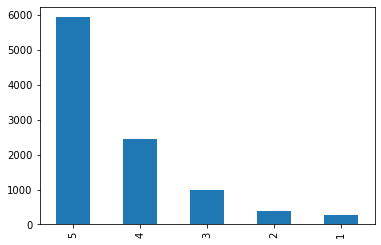

In [23]:
col_int.overall.value_counts().plot(kind = 'bar')

In [24]:
category_mapping = {
1: 'Negative',
2: 'Negative',
3: 'Positive',
4:'Positive',
5:'Positive'
}

col_int['ratings']= col_int['overall'].map(category_mapping)
col_int.head(4)

<ipython-input-24-31086fc2ea44>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_int['ratings']= col_int['overall'].map(category_mapping)


,reviewText,overall,ratings
0,"I bought both boxed sets, books 1-5. Really a...",5,Positive
1,I enjoyed this short book. But it was way way ...,3,Positive
2,I love Nicholas Sparks. I&#8217;ve read everyt...,4,Positive
3,I really enjoyed this adventure and look forwa...,4,Positive


<AxesSubplot:>

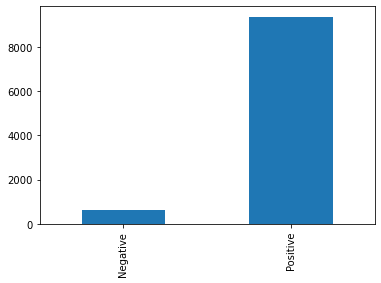

In [25]:
col_int.ratings.value_counts().sort_values().plot(kind = 'bar')

## cleaning text and converting to vectors

Text preprocessing(text_cleaning):
1. Remove symbols. 
2. Remove links(url links). 
3. Remove upper case. (no is different from No which is different from NO! as far as sentiment analysis is concerned).
4. Remove html encodings.
5. Stopwords removal. 
6. Lemmatizing and stemming-breaks down a word to its root form. (e.g eating --> eat: played--> play)

Text engineering techniques. 
1. Bag of words(implemented using count vectorizer or term frequency inverse document frequency). 
2. Word embedding models. 
3. Word to vec tokenization
4. Deep learning models-BERT, ULMFIT, XLM-ROBERTA, ELMO,GPT model - Research on this. 


In [26]:
space_replace = re.compile('[/(){}\[\]\|@,;]')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = nltk.corpus.stopwords.words('english')
urls = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+' 'rt')

def text_cleaning(text):
    text = BeautifulSoup(text, "lxml").text #removing any html decoding
    text = text.lower() #removing capitalization
    text = space_replace.sub(' ', text)#replacing symbols with a space
    text = bad_symbols.sub('', text) #deleting symbols from the text
    text = ' '.join(word for word in text.split() if word not in stopwords) #removing stopwords
    text = urls.sub('', text)#removing urls
    return text

col_int['cleanedtext']= col_int['reviewText'].apply(text_cleaning)
col_int.head(3)

<ipython-input-26-7185bee5f9e5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_int['cleanedtext']= col_int['reviewText'].apply(text_cleaning)


,reviewText,overall,ratings,cleanedtext
0,"I bought both boxed sets, books 1-5. Really a...",5,Positive,bought boxed sets books 15 really great series...
1,I enjoyed this short book. But it was way way ...,3,Positive,enjoyed short book way way short see easily wo...
2,I love Nicholas Sparks. I&#8217;ve read everyt...,4,Positive,love nicholas sparks ive read everything hes w...


## changing text to vectors

There are various methods of changing text to vectors will try a few and see which works better

Compare the results of: 
1. Data that has been cleaned vs non-cleaned data. 
2. Different feature engineering methods( TFIDF vs Count vectorizer)

In [27]:
x_unclean = review_df['reviewText']
x_clean = col_int['cleanedtext']
y_mapping= {
    'Positive':1,
    'Negative': 0
}
col_int['y_encoded']= col_int['ratings'].map(y_mapping)
col_int.head(4)

<ipython-input-27-8aa9bd188a40>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_int['y_encoded']= col_int['ratings'].map(y_mapping)


,reviewText,overall,ratings,cleanedtext,y_encoded
0,"I bought both boxed sets, books 1-5. Really a...",5,Positive,bought boxed sets books 15 really great series...,1
1,I enjoyed this short book. But it was way way ...,3,Positive,enjoyed short book way way short see easily wo...,1
2,I love Nicholas Sparks. I&#8217;ve read everyt...,4,Positive,love nicholas sparks ive read everything hes w...,1
3,I really enjoyed this adventure and look forwa...,4,Positive,really enjoyed adventure look forward reading ...,1


In [28]:
new_col_int = col_int[['cleanedtext', 'y_encoded']]

## text to vecotors

In [29]:
vector = TfidfVectorizer()
X_clean_vector = vector.fit_transform(new_col_int['cleanedtext'])
X_unclean_vector = vector.fit_transform(review_df['reviewText'])
y = col_int['y_encoded']
print(X_clean_vector.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## test train split 
starting with clean data

In [30]:
x_train_cl, x_test_cl, y_train, y_test = train_test_split (X_clean_vector, y, test_size = 0.33, random_state = 42)
x_train_uncl, x_test_uncl, y_train, y_test = train_test_split (X_unclean_vector, y, test_size = 0.33, random_state = 42)


In [31]:
clf_dT =DecisionTreeClassifier()
clf_dT.fit(x_train_cl,y_train)
prediction= clf_dT.predict(x_test_cl)

clf_dT_accurracy = accuracy_score(prediction,y_test )
clf_dT_accurracy

0.9093939393939394

## uncleaned data

In [33]:
clf_dT = DecisionTreeClassifier()
clf_dT.fit(x_train_uncl,y_train)
prediction= clf_dT.predict(x_test_uncl)



vector = TfidfVectorizer()
X_unclean_vector = vector.transform(x_test_cl)
prediction = clf_dT.predict(X_clean_vector)

clf_dT_accurracy = accuracy_score(prediction,y_test )
clf_dT_accurracy

plt.plot(y_test, prediction,marker='o',linestyle='')

NotFittedError: The TF-IDF vectorizer is not fitted

In [34]:
clf_svm = svm.SVC()
clf_svm.fit(x_train_cl,y_train)
prediction = clf_svm.predict(x_test_cl)

clf_svm_accurracy = accuracy_score(prediction,y_test )
clf_svm_accurracy


0.936969696969697

In [ ]:
clf_nb = MultinomialNB()
clf_nb.fit(x_train_cl,y_train)





MultinomialNB()

,reviewText,overall,ratings,cleanedtext,y_encoded
0,"I bought both boxed sets, books 1-5. Really a...",5,Positive,bought boxed sets books 15 really great series...,1
1,I enjoyed this short book. But it was way way ...,3,Positive,enjoyed short book way way short see easily wo...,1
2,I love Nicholas Sparks. I&#8217;ve read everyt...,4,Positive,love nicholas sparks ive read everything hes w...,1
3,I really enjoyed this adventure and look forwa...,4,Positive,really enjoyed adventure look forward reading ...,1
4,It was a decent read.. typical story line. Not...,3,Positive,decent read typical story line nothing unsavor...,1
...,...,...,...,...,...
9995,The whole series was great! Melody is a fanta...,5,Positive,whole series great melody fantastic writer kee...,1
9996,I didn't thing that much of this book. I am a...,3,Positive,didnt thing much book boater lot going boat di...,1
9997,It is an emotional TRIP to the past with Trip ...,5,Positive,emotional trip past trip layla love ease writi...,1
9998,This definitely got under my veins whereby I h...,5,Positive,definitely got veins whereby purchase related ...,1


In [ ]:
col_int.('')